In [52]:
import os

import numpy as np

from matplotlib import pyplot as plt

import pickle
from IPython.display import clear_output

import torch
import torchvision
from torch.utils.data import DataLoader

from sklearn.manifold import TSNE

from datasets import BadNetsDataset, WaNetDataset, SIGDataset
from simclr import SimClrBackbone

In [53]:
device = "cuda"
batch_size = 128

In [54]:
RUN_TSNE = True
RUN_KNN = True
RUN_ENERGY = True

CHECKPOINT_NAME = "SIG-SimCLR-240.pt"

DATASET = "sig"
TRAIN = True

if DATASET == "badnets":
    TARGET_CLASS = 1
elif DATASET == "wanet":
    TARGET_CLASS = 0
elif DATASET == "sig":
    TARGET_CLASS = 0
else:
    raise Exception("Invalid dataset")

## Poison dataset

In [55]:
dataset = torchvision.datasets.CIFAR10(root='C:/Datasets', train=TRAIN)

if DATASET == "badnets":
    poison_dataset = BadNetsDataset(dataset, TARGET_CLASS, "triggers/trigger_10.png", seed=1)
elif DATASET == "wanet":
    poison_dataset = WaNetDataset(dataset, TARGET_CLASS, seed=1)
elif DATASET == "sig":
    poison_dataset = SIGDataset(dataset, TARGET_CLASS, 20, 6, seed=1)
else:
    raise Exception("Invalid dataset")

dataloader = DataLoader(poison_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

## Load SimCLR model

In [56]:
model = SimClrBackbone()

out = os.path.join('./saved_models/', CHECKPOINT_NAME)
checkpoint = torch.load(out, map_location=device)
model.load_state_dict(checkpoint["model_state_dict"])
model = model.to(device)
model.eval()

c:\Users\Luka\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Luka\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


SimClrBackbone(
  (pretrained): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): Identity()
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): C

## Extract features for all images

In [57]:
features = None
labels_poison = None
labels_true = None

for i, (img, labels_batch_poison, labels_batch_true) in enumerate(dataloader):

    with torch.no_grad():
        features_batch = model(img.to(device)).cpu().data.numpy()
        
    if features is None:
        features = features_batch
        labels_poison = labels_batch_poison
        labels_true = labels_batch_true
    else:
        features = np.append(features, features_batch, axis=0)
        labels_poison = np.append(labels_poison, labels_batch_poison, axis=0)
        labels_true = np.append(labels_true, labels_batch_true, axis=0)

num_classes = max(labels_poison)


## Plot t-SNE features

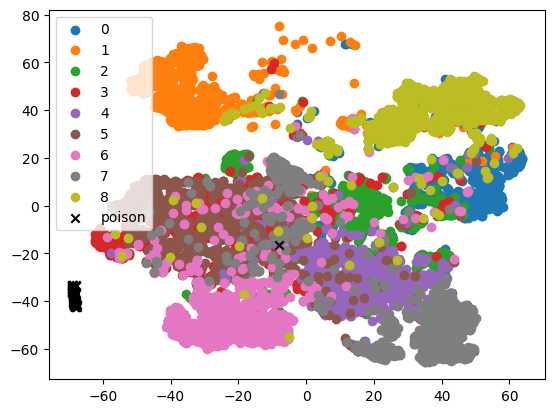

In [58]:
if RUN_TSNE:

    # label poison examples as 10
    labels = labels_true[:]
    labels[[poison_dataset.is_poison(i) for i in range(len(labels))]] = 10

    # Plot only a subset
    subset_size = 10000
    features_subset = features[:subset_size]
    labels_subset = labels[:subset_size]
        
    tsne = TSNE(n_components = 2, perplexity = 50)
    tsne_features = tsne.fit_transform(features_subset)

    for i in range(num_classes):
        plt.scatter(tsne_features[labels_subset==i,1], tsne_features[labels_subset==i,0])
    plt.scatter(tsne_features[labels_subset==10,1], tsne_features[labels_subset==10,0], c = "black", marker= "x")

    plt.legend([str(i) for i in range(num_classes)] + ["poison"])
    plt.show()

## kNN clean

In [59]:
if RUN_KNN:

    from sklearn.neighbors import KNeighborsClassifier

    examples_per_class = len(dataset) / num_classes

    knn = KNeighborsClassifier(n_neighbors=int(examples_per_class/2))
    knn.fit(features, labels_poison)

In [60]:
if RUN_KNN:

    tp = 0
    fp = 0
    tn = 0
    fn = 0

    predicted_labels = []

    for i in range(len(dataset)):
        feature = features[i]
        poison_label = labels_poison[i]
        true_label = labels_true[i]
        predicted_label = knn.predict(np.expand_dims(feature,0))[0]

        predicted_labels.append(predicted_label)

        true_poison = poison_dataset.is_poison(i)
        predicted_poison = poison_label != predicted_label

        if true_poison and predicted_poison:
            tp += 1
        elif not true_poison and predicted_poison:
            fp += 1
        elif true_poison and not predicted_poison:
            fn += 1
        else:
            tn += 1

        if i % 100 == 0:
            clear_output(wait=True)
            print(f"{i} / {len(dataset)}")
            print(f"\t {tp} \t {fp}")
            print(f"\t {fn} \t {tn}")

            fnr = fn/(fn+tp) if fn+tp!=0 else 0
            tnr = tn/(tn+fp) if tn+fp!=0 else 0
            poison_rate = fn/(fn+tn) if fn+tn!=0 else 0
            print(f"Percentage of poisoned images (out of all poisoned) kept: {100*fnr: .2f}%")
            print(f"Percentage of clean images (out of all clean) kept: {100*tnr: .2f}%")
            print(f"Percentage of remaining poisoned images (out of all remaining): {100*poison_rate: .2f}%")

    clear_output(wait=True)
    print(f"{len(dataset)} / {len(dataset)}")
    print(f"\t {tp} \t {fp}")
    print(f"\t {fn} \t {tn}")

    fnr = fn/(fn+tp) if fn+tp!=0 else 0
    tnr = tn/(tn+fp) if tn+fp!=0 else 0
    poison_rate = fn/(fn+tn) if fn+tn!=0 else 0
    print(f"Percentage of poisoned images (out of all poisoned) kept: {100*fnr: .2f}%")
    print(f"Percentage of clean images (out of all clean) kept: {100*tnr: .2f}%")
    print(f"Percentage of remaining poisoned images (out of all remaining): {100*poison_rate: .2f}%")

13500 / 50000
	 36 	 2683
	 98 	 10684
Percentage of poisoned images (out of all poisoned) kept:  73.13%
Percentage of clean images (out of all clean) kept:  79.93%
Percentage of remaining poisoned images (out of all remaining):  0.91%


KeyboardInterrupt: 

------------------------------------

CIFAR-10 train \
BadNets 

    50000 / 50000
        4973 	 9347
        27 	 35653
    Percentage of poisoned images (out of all poisoned) kept:  0.54%
    Percentage of clean images (out of all clean) kept:  79.23%
    Percentage of remaining poisoned images (out of all remaining):  0.08%

CIFAR-10 test \
BadNets \

    10000 / 10000
        997 	 1966
        3 	 7034
    Percentage of poisoned images (out of all poisoned) kept:  0.30%
    Percentage of clean images (out of all clean) kept:  78.16%
    Percentage of remaining poisoned images (out of all remaining):  0.04%

------------------------------------

CIFAR-10 train \
WaNet 

    50000 / 50000
        4892 	 10176
        108 	 34824
    Percentage of poisoned images (out of all poisoned) kept:  2.16%
    Percentage of clean images (out of all clean) kept:  77.39%
    Percentage of remaining poisoned images (out of all):  0.31%

CIFAR-10 test \
WaNet 

    10000 / 10000
        952     2148
        48 	    6852
    Percentage of poisoned images (out of all poisoned) kept:  4.80%
    Percentage of clean images (out of all clean) kept:  76.13%
    Percentage of remaining poisoned images (out of all): 0.69%

------------------------------------

CIFAR-10 test \
SIG

    50000 / 50000
        0 	 9195
        500 	 40305
    Percentage of poisoned images (out of all poisoned) kept:  100.00%
    Percentage of clean images (out of all clean) kept:  81.42%
    Percentage of remaining poisoned images (out of all remaining):  1.23%

In [ ]:
if RUN_KNN:

    save_name = "Poison-kNN-split"

    with open(f"./cleansed_labels/{save_name}.pkl", "wb") as f:
        pickle.dump(predicted_labels, f)

## Energy clean

In [ ]:
class EnergyClassifier():

    def __init__(self, t=1):
        self.t = t

    def fit(self, X, y):
        self.X = X
        self.y = y
        
        self.C = np.max(y)
        self.Ic = {c:[i for i in range(len(y)) if y[i]==c] for c in range(self.C)}
        
    def predict_index(self, i):
        xi = self.X[i]

        exp_all = np.exp([xi*self.X[k]/self.t for k in range(len(self.X))])
        sum_exp_all_except_xi = np.sum([exp_all[k] for k in range(len(self.X)) if k!=i])
        mean_exp_c = [np.mean([exp_all[k] for k in self.Ic[c] if k!=i]) for c in range(self.C)]
    
        Scs = mean_exp_c / sum_exp_all_except_xi
        return np.argmax(Scs)


if RUN_ENERGY:
    energy = EnergyClassifier(t=1)
    energy.fit(features, labels_poison)

In [ ]:
if RUN_ENERGY:
    tp = 0
    fp = 0
    tn = 0
    fn = 0

    predicted_labels = []

    for i in range(len(dataset)):
        poison_label = labels_poison[i]
        true_label = labels_true[i]
        predicted_label = energy.predict_index(i)

        predicted_labels.append(predicted_label)

        true_poison = poison_dataset.is_poison(i)
        predicted_poison = poison_label != predicted_label

        if true_poison and predicted_poison:
            tp += 1
        elif not true_poison and predicted_poison:
            fp += 1
        elif true_poison and not predicted_poison:
            fn += 1
        else:
            tn += 1

        if i % 100 == 0:
            clear_output(wait=True)
            print(f"{i} / {len(dataset)}")
            print(f"\t {tp} \t {fp}")
            print(f"\t {fn} \t {tn}")

            fnr = fn/(fn+tp) if fn+tp!=0 else 0
            tnr = tn/(tn+fp) if tn+fp!=0 else 0
            poison_rate = fn/(fn+tn) if fn+tn!=0 else 0
            print(f"Percentage of poisoned images (out of all poisoned) kept: {100*fnr: .2f}%")
            print(f"Percentage of clean images (out of all clean) kept: {100*tnr: .2f}%")
            print(f"Percentage of remaining poisoned images (out of all remaining): {100*poison_rate: .2f}%")


    clear_output(wait=True)
    print(f"{len(dataset)} / {len(dataset)}")
    print(f"\t {tp} \t {fp}")
    print(f"\t {fn} \t {tn}")

    fnr = fn/(fn+tp) if fn+tp!=0 else 0
    tnr = tn/(tn+fp) if tn+fp!=0 else 0
    poison_rate = fn/(fn+tn) if fn+tn!=0 else 0
    print(f"Percentage of poisoned images (out of all poisoned) kept: {100*fnr: .2f}%")
    print(f"Percentage of clean images (out of all clean) kept: {100*tnr: .2f}%")
    print(f"Percentage of remaining poisoned images (out of all remaining): {100*poison_rate: .2f}%")

50000 / 50000
	 2 	 15777
	 498 	 33723
Percentage of poisoned images (out of all poisoned) kept:  99.60%
Percentage of clean images (out of all clean) kept:  68.13%
Percentage of remaining poisoned images (out of all remaining):  1.46%


CIFAR-10 train \
BadNets

	50000 / 50000
		4967 	 8850
		33 	 36150
	Percentage of poisoned images (out of all poisoned) kept:  0.66%
	Percentage of clean images (out of all clean) kept:  80.33%
	Percentage of remaining poisoned images (out of all remaining):  0.09%

CIFAR-10 test \
BadNets

	10000 / 10000
		995 	 1820
		5 	 7180
	Percentage of poisoned images (out of all poisoned) kept:  0.50%
	Percentage of clean images (out of all clean) kept:  79.78%
	Percentage of remaining poisoned images (out of all remaining):  0.07%

--------------------------------------------------------------------------------

CIFAR-10 train \
WaNet

	50000 / 50000
		4922 	 9918
		78 	 35082
	Percentage of poisoned images (out of all poisoned) kept:  1.56%
	Percentage of clean images (out of all clean) kept:  77.96%
	Percentage of remaining poisoned images (out of all remaining):  0.22%

CIFAR-10 test \
WaNet

	10000 / 10000
		967 	 2050
		33 	 6950
	Percentage of poisoned images (out of all poisoned) kept:  3.30%
	Percentage of clean images (out of all clean) kept:  77.22%
	Percentage of remaining poisoned images (out of all remaining):  0.47%

--------------------------------------------------------------------------------

CIFAR-10 train \
SIG

	50000 / 50000
		2 	 15777
		498 	 33723
	Percentage of poisoned images (out of all poisoned) kept:  99.60%
	Percentage of clean images (out of all clean) kept:  68.13%
	Percentage of remaining poisoned images (out of all remaining):  1.46%

In [ ]:
if RUN_ENERGY:

    save_name = "Poison-Energy-split"

    with open(f"./cleansed_labels/{save_name}.pkl", "wb") as f:
        pickle.dump(predicted_labels, f)